Lectures 4-5: Modeling bulk transport

In [2]:
nb_list = !jupyter notebook list
server = [l for l in nb_list if 'EOS423' in l][0].split(' :: ')[0]
prefix = server.split('?')[0]
token = server.split('?')[1]
notebook = 'Lecture4.ipynb'
url = prefix+'notebooks/'+notebook+'?'+token
!decktape --slides 1,46-90 -s '1920x1080' rise $url PDF_Slides/2023/Lecture5.pdf

Loading page http://localhost:8888/notebooks/Lecture4.ipynb?token=47a695f7fb995092aab5f678371bf6978faae8df2a890632 ...
actions jupyter-notebook:find-and-replace does not exist, still binding it in case it will be defined later...
load_extensions {
  '0': 'nbextensions_configurator/config_menu/main',
  '1': 'contrib_nbextensions_help_item/main',
  '2': 'rise/main',
  '3': 'jupyter-js-widgets/extension',
  '4': 'jupyter-black-master/jupyter-black',
  '5': 'toc2/main',
  '6': 'hide_code/hide_code',
  '7': 'hide_input/main',
  '8': 'codefolding/main',
  '9': 'splitcell/splitcell'
}
Loaded moment locale en-gb
Failed to load resource: the server responded with a status of 404 (Not Found)
HTML Sanitizer div.style changed {
  change: 'changed',
  tagName: 'div',
  attribName: 'style',
  oldValue: 'background: url(images/SA_seds.jpg) 50% 35% no-repeat;\n' +
    '  width: 100vw;\n' +
    '  height: 30vh; background-size: 100%;',
  newValue: 'background: url("images/SA_seds.jpg") 50% 35% no-repea

Session: kernel_created (98c05f82-567b-4a4f-82f4-efb788e50c5e)
Starting WebSockets: ws://localhost:8888/api/kernels/c669fa8a-9329-4de9-8d0a-81850d485322
Failed to load extension: [ 'nbextensions/hide_code/hide_code' ] {
  requireType: 'scripterror',
  requireModules: [ 'nbextensions/hide_code/hide_code' ],
  originalError: { isTrusted: true }
}
Loading extension: nbextensions_configurator/config_menu/main
Loading extension: contrib_nbextensions_help_item/main
Loading extension: rise/main
Loading extension: splitcell/splitcell
Loading extension: hide_input/main
Kernel: kernel_connected (c669fa8a-9329-4de9-8d0a-81850d485322)
Loading extension: jupyter-js-widgets/extension
Failed to load resource: the server responded with a status of 404 (Not Found)
Widgets are not available.  Please install widgetsnbextension or ipywidgets 4.0
Loading extension: jupyter-black-master/jupyter-black
Loading extension: toc2/main
[toc2] Notebook fully loaded -- toc2 initialized 
Loading extension: codefoldin

In [1]:
from scipy.linalg import solve_banded
from scipy.interpolate import interp1d
import numpy as np
from tqdm.notebook import tqdm
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import clear_output
import seaborn as sns
import matplotlib.cm as cm
import time
sns.set_context('talk')

%matplotlib inline

class Diffuse1D:
    def __init__(self, length, spacing, tstep, left, right, K):
        self.x = np.arange(0, length, spacing)
        self.u = (
            left - self.x * (left - right) / length
        )  # sets initial to steady state solution
        
        self.u = (
            left - self.x * (left - right) / length
        )  # sets initial to steady state solution
        #         self.u = np.zeros(self.x.shape)+right
        N = self.x.size
        self.tstep = tstep
        self.spacing = spacing
        self.K = K
        k_arr = K * np.ones((N))  # m^2/yr
        self.r = k_arr * (self.tstep / (2 * spacing ** 2))  ##Fourier number
        self.time = 0
        self.base_level_fun = interp1d([0, 1], [0, 0], bounds_error=False, fill_value=0)
        self.base_level = self.base_level_fun(self.time)
        self.sed_Q = 100 / spacing  # not sure if spacing is correct here
        self.subsidence_r = 0.025 * 1e-3 * 1e1  # not in use yet
        self.left = left
        self.right = right

        # initialize matrices A, B and b array
        self.A = np.zeros((N, N))
        self.B = np.zeros((N, N))
        self.b = np.zeros((N))
        # define matrices A, B and b array  ##THIS STEP IS SLOW -- but only called once
        # see method update_K() for fast version
        for i in range(N):
            if i == 0:  # first
                self.A[i, :] = [
                    1 + 2 * self.r[j] if j == 0 else (-self.r[j]) if j == 1 else 0
                    for j in range(N)
                ]
                self.B[i, :] = [
                    1 - 2 * self.r[j] if j == 0 else self.r[j] if j == 1 else 0
                    for j in range(N)
                ]
                self.b[i] = left  # boundary condition at i=1
            elif i == N - 1:  # last
                self.A[i, :] = [
                    -self.r[j] if j == N - 2 else 1 + 2 * self.r[j] if j == N - 1 else 0
                    for j in range(N)
                ]
                self.B[i, :] = [
                    self.r[j] if j == N - 2 else 1 - 2 * self.r[j] if j == N - 1 else 0
                    for j in range(N)
                ]
                self.b[i] =  right  # boundary condition at i=N
            else:  # middles
                self.A[i, :] = [
                    -self.r[j]
                    if j == i - 1 or j == i + 1
                    else 1 + 2 * self.r[j]
                    if j == i
                    else 0
                    for j in range(N)
                ]
                self.B[i, :] = [
                    self.r[j]
                    if j == i - 1 or j == i + 1
                    else 1 - 2 * self.r[j]
                    if j == i
                    else 0
                    for j in range(N)
                ]

        #von nuemann bottom
#         self.A[-1,-1] = 1+self.r[-1]
#         self.B[-1,-1] = 1-self.r[-1]
#         self.b[-1]=0
        
        self.Ab = np.zeros((3, N))
        self.Ab[0, 1:] = np.diag(self.A, -1)
        self.Ab[1, :] = np.diag(self.A)
        self.Ab[2, :-1] = np.diag(self.A, 1)
        self.Q = np.zeros((N))
        self.bb = self.B.dot(self.u) + 2 * self.r*self.b + self.tstep*self.Q

        self.update_coastline()

    def set_baselevel(self, time, rsl):
        # can pass a set of paired time/rsl and model will interpolate for each dt
        self.base_level_fun = interp1d(time, rsl)

    def run_step(self):
        #self.update_K()  # can disable if K is not changing with each t_step (ie as a function of elevation)
        self.Q *= 0  # clearing any old sed flux terms
        self.base_level = self.base_level_fun(self.time)  # update base level
        self.update_coastline()  # select coastline point for sed flux
        self.Q[self.coastline] += self.sed_Q  # add sediment to the coastline
        self.bb = self.B.dot(self.u) + 2 * self.r*self.b + self.tstep*self.Q  # quick matrix addition
        self.u = solve_banded(
            (1, 1), self.Ab, self.bb
        )  # this step solves the Crank-Nicholson matrix for next timestep
        self.time += self.tstep  # increment timestep

    def set_left(self, left):
        # function to change boundary condition
        self.b[0] = left

    def set_u(self, u):
        self.u = u

    def set_right(self, right):
        # function to change boundary condition
        self.b[-1] = right

    def update_coastline(self):
        # finds the first grid point below base level starting on the left hand side
        try:
            self.coastline = np.where(self.u < (self.base_level))[0][0]
        except:
            self.coastline = 0

    def update_K(self):
        # updates K if you need it to change with each timestep
        # the tridiagonal matrix forms below dont need to be inverted, so this is
        # a much faster form of setting up the Crank-Nicolson solution
        k_arr = self.K * np.ones((self.x.size))
        k_arr[: self.coastline] = 1e-2
#         swb = np.where(self.u < (self.base_level - 25))[0][0] #lower K below SWB?
#         k_arr[swb:] = 1e-2
        self.r = k_arr * (self.tstep / (2 * self.spacing ** 2))  ##Fourier number
        np.fill_diagonal(self.B, 1 - 2 * self.r)
        np.fill_diagonal(self.B[1:], self.r[1:])
        np.fill_diagonal(self.B[:, 1:], self.r[:-1])
        self.Ab[0, 1:] = -1 * self.r[:-1]
        self.Ab[1, :] = 1 + 2 * self.r
        self.Ab[2, :-1] = -1 * self.r[1:]
        
        #should the R_i match??  go back a few steps and check the full form
        
        #von nuemann bottom
#         self.Ab[1, -1] = 1+self.r[-1]
#         self.B[-1,-1] = 1-self.r[-1]
#         self.b[-1]=0
#         self.b[0] = self.left
#         self.b[-1] = self.right

def animate_beds(beds,otime,rsl, color=True, aspect=10, ymin=-55):
    N = int(len(beds) / 2) + 1
    cs_reg = sns.color_palette("viridis", n_colors=np.sum(np.gradient(rsl) <= 0))
    cs_trans = sns.color_palette("Greys", n_colors=np.sum(np.gradient(rsl) > 0))
    rsl_down = np.gradient(rsl) <= 0
    if color==False:
        cs_reg = sns.color_palette("Greys", n_colors=100*np.sum(np.gradient(rsl) <= 0))
        cs_trans = sns.color_palette("Greys", n_colors=100*np.sum(np.gradient(rsl) > 0))

    sns.set_palette("tab20", n_colors=40)
    
    minima = min(np.gradient(rsl))
    maxima = max(np.gradient(rsl))
    max_max = max([minima,maxima])

    norm = matplotlib.colors.Normalize(vmin=-1*max_max, vmax=max_max, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdBu)

    # for k in range(len(beds)):
    #         beds[k]-=otime[k]*model.subsidence_r

    beds = np.array(beds)
    for i, bed in enumerate(beds):

        beds_eroded = []

        for k, layer in enumerate(beds[:i]):
            future_min = np.min(beds[k : i + 1], axis=0)
            beds_eroded.append(future_min)
        #         beds_eroded.append(layer)

        beds_eroded.append(beds[i])
        beds_eroded = np.array(beds_eroded)

        fig = plt.figure(figsize=(18, 12))
        clear_output(wait=True)
        c = [0, 0]
        z = N + 1
        last_layer = beds_eroded[0]
        for layer, down in zip(beds_eroded[: i + 1], np.gradient(rsl)):
            if down:
                plt.fill_between(
                    np.arange(layer.size),
                    last_layer,
                    layer,
                    facecolor=mapper.to_rgba(down),
                    lw=0.5,
                    edgecolor=(0, 0, 0),
                )
                c[0] += 1
            else:
                plt.fill_between(
                    np.arange(layer.size),
                    last_layer,
                    layer,
                    facecolor=cs_trans[c[1]],
                    lw=0.1,
                    edgecolor=(0, 0, 0),
                )
                c[1] += 1
            z -= 1
            last_layer = np.copy(layer)

        plt.plot(bed, color="r", zorder=N * 2 + 1)
        plt.plot([0, 1000], [rsl[i], rsl[i]], "--", color="k")

        plt.gca().set_xlim([0, layer.size])
        plt.gca().set_ylim([ymin, 0])
        plt.gca().set_aspect(aspect)
        #     plt.gca().set_title('Regression (color) and Transgression (greyscale)\n with Constant Sed Flux (vertical exaggeration: 100)')
        plt.gca().set_title("time=" + str(np.round(otime[i], 2)) + " years")
        plt.gca().set_ylabel("height (m)")
        plt.gca().set_xlabel("distance (10x meters)")
        plt.show()
        time.sleep(0.01)

In [2]:
def plt_strat():
    beds_eroded = []
    for i,layer in enumerate(beds):
        future_min = np.min(beds[i:],axis=0)
        beds_eroded.append(future_min)

    N=int(len(beds_eroded)/2)+1
    cs_reg=sns.color_palette('viridis',n_colors=np.sum(np.gradient(rsl)<=0))
    cs_trans=sns.color_palette('Greys',n_colors=np.sum(np.gradient(rsl)>0))
    rsl_down=np.gradient(rsl)<=0

    minima = min(np.gradient(rsl))
    maxima = max(np.gradient(rsl))
    max_max = max([minima,maxima])

    norm = matplotlib.colors.Normalize(vmin=-1*max_max, vmax=max_max, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdBu)

    sns.set_palette('tab20',n_colors=40)
    fig=plt.figure(figsize=(8,12))
    for k in range(1,10):
        plt.subplot(1,9,k)
        c=[0,0]
        z=N+1
        last_layer=beds_eroded[0]
        for layer,down in zip(beds_eroded,np.gradient(rsl)):
            if True:
                plt.fill_between(np.arange(layer.size),last_layer,layer,facecolor=mapper.to_rgba(down),lw=0,edgecolor=(0,0,0))
        #         plt.plot(layer,c=cs_reg[c[0]],zorder=z)
                c[0]+=1
            else:
                plt.fill_between(np.arange(layer.size),last_layer,layer,facecolor=cs_trans[c[1]],lw=0,edgecolor=(0,0,0))
                c[1]+=1
            z-=1
            last_layer=np.copy(layer)
        plt.gca().set_xlim([k*100/2,k*100/2+0.01])
        plt.gca().set_ylim([-100,10])
        plt.gca().set_aspect(.001)
        plt.gca().set_title(str(k/2)+' km',fontsize=12)
        plt.gca().set_xticks([])
        if k==1:
            plt.gca().set_ylabel('height (m)')
        else:
            plt.gca().set_yticks([])
    return fig

In [3]:
dt = .01
total_time = 2000
base_level_rise=5

model = Diffuse1D(length=10000, spacing=10, tstep=dt, left=10, right=-200, K=1e2)
xt = np.linspace(0, 10000, 10000)

model.set_baselevel(xt, -10 * np.sin(xt * 3e-2) + base_level_rise / (total_time) * xt - 25)

beds = []
otime = []
rsl = []
# plt.plot(model.u)

beds.append(model.u)
otime.append(model.time)
rsl.append(model.base_level)


pbar = tqdm(range(int(total_time / dt)+1))
for k in pbar:
    model.run_step()
    #     model.set_left(model.base_level+10)
    if k % 2000 == 0:
        pbar.set_description("Processing year %s" % np.round(model.time, 1))
        beds.append(model.u)
        otime.append(model.time)
        rsl.append(model.base_level)

  0%|          | 0/200001 [00:00<?, ?it/s]

<center><div style="background: url(images/SA_seds.jpg) 50% 35% no-repeat;
  width: 100vw;
  height: 30vh; background-size: 100%;">
</div></center>

# Lectures 4-6: Modeling Bulk Transport (numerically)

<div style='font-size:25px'>
    
    
1. Kenyon and Turcotte (1985)
    1. Diffusion as a transport mechanism
1. A more powerful diffusive model
    1. Live example with variable sea level
    1. Solving the diffusion equation numerically
        1. The derivative function
        1. Finite difference methods
    1. An explicit solution to the diffusion equation
        1. Stability
    2. An implicit solution to the diffusion equation


</div>

# Kenyon and Turcotte (1985): Diffusion

<center>
    <div style='height:60vh;float: left;
  width: 50%;
  padding: 5px;'>
	    <img src="images/rhine_map.jpg" style='height:60vh'>
    </div>
        <div style='height:60vh;float: left;
  width: 50%;
  padding: 5px;'>
	    <img src="images/rhine_data.jpg" style='height:60vh'>
    </div>
</center>

K&T to convince you that diffusion, or bulk sediment transport, is a reasonable approximation

## Diffusion as a transport mechanism
When we assume that **diffusive transport** exerts an important control on landscape dynamics we generally accept that particles on the surface of the planet are in constant complex motion, and there is some **downslope bias introduced by gravity** to those motions. Over time, **diffusion** can be assumed to smooth topography (by the transport of material downslope).
<center></center>
$$\begin{equation}
\dfrac{\partial h}{\partial t}
= 
K \dfrac{\partial^2 h}{\partial x^2}\tag{hillslope application}
\end{equation}$$

# A more powerful diffusion model
Over the next few weeks in your assignments you will be building a 1-D diffusive transport model to explore how variations in the following properties change the stratigraphic **architecture** of a basin:
1. transport
2. sediment supply
3. accomodation space

# An example: varying accomodation space

Text(0, 0.5, 'Base level')

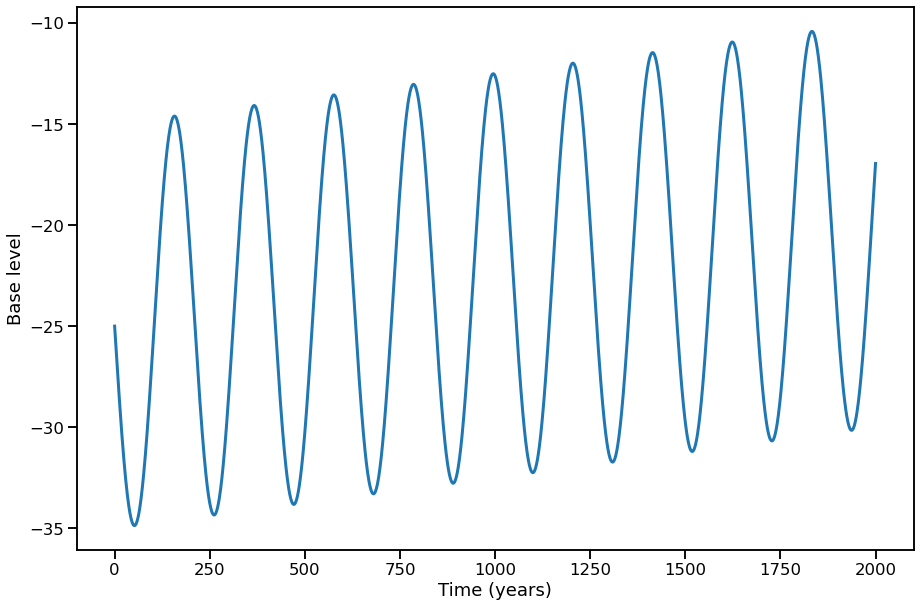

In [4]:
x_ran = np.linspace(0,total_time,len(pbar))
fig=plt.figure(figsize=(15,10))
plt.plot(x_ran,model.base_level_fun(x_ran), lw=3)
plt.gca().set_xlabel('Time (years)')
plt.gca().set_ylabel('Base level')

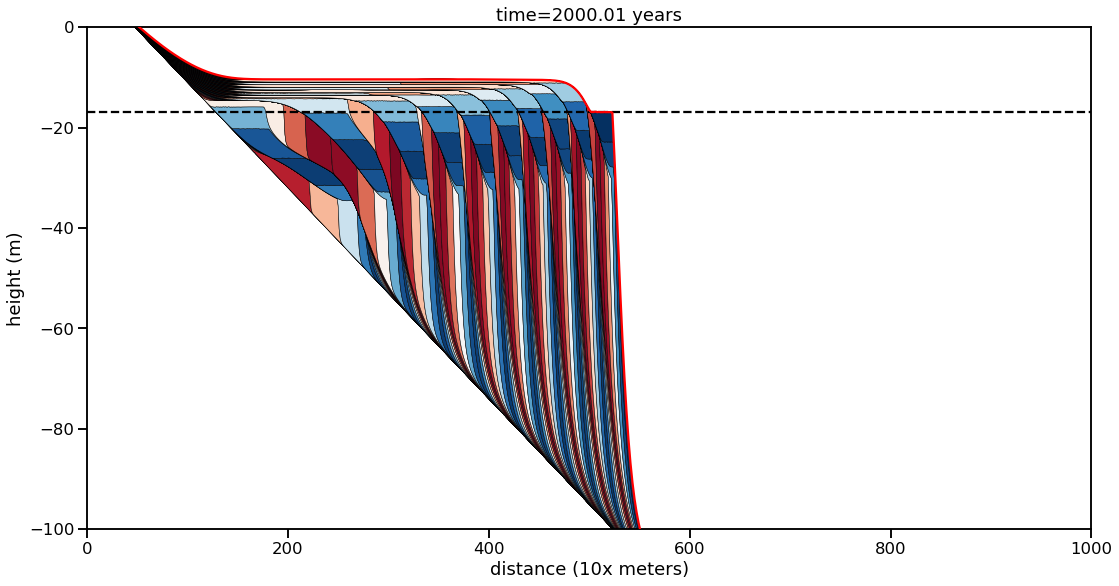

In [5]:
animate_beds(beds=beds,otime=otime,rsl=rsl,aspect=5, ymin=-100)

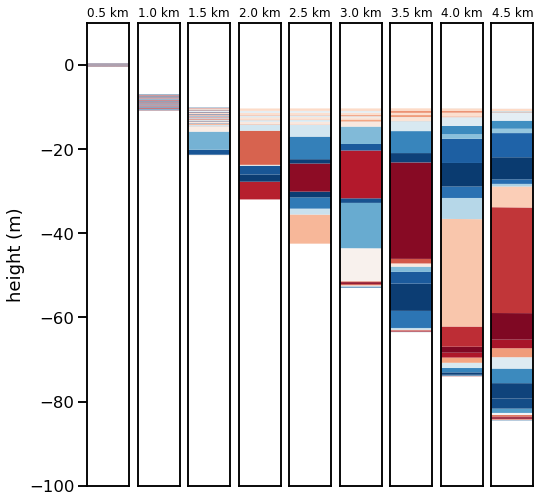

In [6]:
fig=plt_strat()

In [ ]:
x_ran = np.linspace(0,total_time,len(pbar))
plt.plot(x_ran,model.base_level_fun(x_ran))
plt.gca().set_xlabel('Time (years)')
plt.gca().set_ylabel('Base level')

In [ ]:
animate_beds(beds=beds,otime=otime,rsl=rsl,aspect=5, ymin=-100)

## Solving the diffusion equation numerically
We can use the diffusion equation to simulate more complicated transport than the specific case from *Kenyon and Turcott 1985*. Generally, after defining a few properties of the system <span style='color:DodgerBlue'>**(What properties?)**</span> we can solve how that system will change over time. However, there is no exact, or **analytical** form to this solution -- we must solve the equation by numerical approximation.
<center></center>
$$\begin{equation}
\dfrac{\partial h}{\partial t}
= 
K \dfrac{\partial^2 h}{\partial x^2}
\end{equation}$$

<center>
    <div style='height:40vh;'>
	    <p>
    </div>
</center>

<span style='color:DodgerBlue'>**(initial topography, boundary conditions at the edges)**</span>

### The Derivative Function
Recall: what is the definition of the derivative function $f'(x)$?

$$
\begin{equation}
f'(x)
=
\lim_{\Delta x\to0}
\dfrac{f(x+\Delta x)-f(x)}{\Delta x}
\end{equation}
=
\dfrac{\Delta f}{\Delta x}
$$


<center>
    <div style='height:40vh;'>
	    <p>
    </div>
</center>

<span style='color:DodgerBlue'>**While we can't calculate $\Delta x$ and $\Delta f$ for $\lim{(\Delta x\to0)}$ CPUs have no trouble calculating $\dfrac{\Delta f}{\Delta x}$ for a sufficiently small value of $\Delta x$**</span>

### Finite difference methods
In fact, we have many possible approaches to estimating derivatives using *sufficiently small* values of $\Delta x$, and these methods are collectively known as **finite difference methods**. These methods make use of <span style='color:DodgerBlue'>**Taylor's theorem**</span>:

$\begin{equation} f(x + \Delta x) = f(x) + \dfrac{f'(x)}{1!}(\Delta x) + \dfrac{f''(x)}{2!}(\Delta x)^2 + ... \end{equation} \label{eq:taylor}\tag{Taylor series} $  

<span style='color:DodgerBlue'>**What happens to the size of each higher order term in the series?**</span>

We describe the error of an approximation by the degree of the term where the series is truncated. First order: $O(\Delta x)$, second order: $O(\Delta x^2)$, third order: $O(\Delta x^3)$, etc...

$$
\begin{equation} f(x + \Delta x) \color{red}{\approx} f(x) + \dfrac{f'(x)}{1!}(\Delta x) 
\color{Gray}{+ \dfrac{f''(x)}{2!}(\Delta x)^2 + ...} 
\end{equation}
$$  

<span style='color:DodgerBlue'>**The forward-difference approximation of the first derivative with error $O(\Delta x)$:**</span>

$$
\begin{equation} 
f'(x) = \dfrac{f(x+\Delta x)-f(x)}{\Delta x}
\end{equation}
$$  

<span style='color:DodgerBlue'>**Any guesses to what the backward-difference looks like?**</span>

$$
\begin{equation} 
f'(x) = \dfrac{f(x) - f(x-\Delta x)}{\Delta x}
\end{equation}
$$  

For this next part, it helps to consider a more specific case where we know our function $f(x)$ for values of $x$ separated by $\Delta x$. Let's call our function $h(x)$ for height or topography. (Draw cartoon of topography at a single timestep)

<center>
    <div style='height:40vh;'>
	    <p>
    </div>
</center>

<table>
<tr>
    <th><center> General </center></th>
    <th  style='width:100px'>  </th>
<th><center> Specific </center></th>
</tr>
<tr>
<td>

$$\begin{equation} f(x + \Delta x) = f(x) + \dfrac{\color{Blue}{f'(x)}}{1!}(\Delta x) + \dfrac{\color{Blue}{f''(x)}}{2!}(\Delta x)^2 + ... \end{equation}  $$ 
    
$$\begin{equation} f(x \color{red}{-} \Delta x) = f(x) + \dfrac{\color{Blue}{f'(x)}}{1!}(\color{red}{-}\Delta x) + \dfrac{\color{Blue}{f''(x)}}{2!}(\color{red}{-}\Delta x)^2 + ... \end{equation}  $$  

</td>
    <td>
    </td>
<td>

$$\begin{equation} right = center + \color{Blue}{h'(x)}\Delta x + \dfrac{\color{Blue}{h''(x)}}{2}\Delta x^2 \end{equation}  $$ 
    
$$\begin{equation} left = center \color{red}{-} \color{Blue}{h'(x)}\Delta x + \dfrac{\color{Blue}{h''(x)}}{2}\Delta x^2 \end{equation}  $$  

</td>
</tr>
</table>



 



**Using these two second-order truncations of the Taylor series, derive approximations for both of the <span style='color:blue'>unknowns</span> (first and second derivative)**

$$\begin{equation} 
\color{blue}{h''(x_i)} \approx 
\dfrac{\mathrm{left} - 2~\mathrm{center} + \mathrm{right}}{\Delta x^2}
\tag{central-difference $\frac{\partial^2 h}{\partial x^2}$}
\end{equation} $$ 

$$\begin{equation} 
\color{blue}{h'(x_i)} \approx \dfrac{\mathrm{right}-\mathrm{left}}{2\Delta x}
\tag{central-difference $\frac{\partial h}{\partial x}$}
\end{equation} $$ 

#### Explicit solution
All this algebra leads us to an **explicit** solution to the diffusion equation:
$$\begin{equation}
\dfrac{\partial h}{\partial t}
= 
K \color{blue}{\dfrac{\partial^2 h}{\partial x^2}}
\end{equation}$$


$$\begin{equation}
\dfrac{\partial h}{\partial t}
\color{red}{\approx}
K \color{blue}{\dfrac{\mathrm{left} - 2~\mathrm{center} + \mathrm{right}}{\Delta x^2}}
\end{equation}$$

<span style='color:DodgerBlue'>**How do we handle $\dfrac{\partial h}{\partial t}$?**</span> 


Let's look at a space-time grid for the problem..


<center>
    <div style='height:40vh;'>
	    <p>
    </div>
</center>

Since we want to solve for the future timestep, we need to use an approximation for $\dfrac{\partial h}{\partial t}$ that includes the current time-step (**known**) and the future time-step (<span style='color:blue'>**unknown**</span>). We will use the forward difference approximation for time:


<table>
<tr>
    <th><center> General </center></th>
    <th  style='width:100px'>  </th>
<th><center> Specific </center></th>
</tr>
<tr>
<td>



$$
\begin{equation} 
f'(x) \approx \dfrac{f(x+\Delta x)-f(x)}{\Delta x}
\end{equation}
$$  


</td>
    <td>
    </td>
<td>

$$\begin{equation} 
\dfrac{\partial h}{\partial t}
\approx 
\dfrac{future-now}
{\Delta t}
\end{equation}  $$ 


</td>
</tr>
</table>







$$\begin{equation}
\dfrac{\partial h}{\partial t}
\color{red}{\approx}
K \dfrac{\mathrm{left} - 2~\mathrm{center} + \mathrm{right}}{\Delta x^2}
\end{equation}$$

$$\begin{equation}
\dfrac{\mathrm{\color{Blue}{future}-now}}
{\Delta t}
\color{red}{\approx}
K \dfrac{\mathrm{left} - 2~\mathrm{center} + \mathrm{right}}{\Delta x^2}
\end{equation}$$


$$\begin{equation}
\dfrac{\mathrm{\color{Blue}{future}-now}}
{1}
\color{red}{\approx}
\dfrac{K\Delta t}{\Delta x^2} \dfrac{\mathrm{left} - 2~\mathrm{center} + \mathrm{right}}{1}
\end{equation}$$

<center>Let $r=\dfrac{K\Delta t}{\Delta x^2}$

$$\begin{equation}
\mathrm{\color{Blue}{future}}
\color{red}{\approx}
r \left(\mathrm{left} - 2~\mathrm{center} + \mathrm{right}\right) + \mathrm{now}
\end{equation}$$

<span style='color:DodgerBlue'>**Recall: what is meant by the word $\mathrm{now}$ in this equation?**</span> 


$$\mathrm{now = center}$$

$$
\begin{equation}
\mathrm{\color{Blue}{future}}
\color{red}{\approx}
r~\mathrm{left} - 2~r~\mathrm{center} + r~\mathrm{right} + \mathrm{center}
\end{equation}
$$

$$
\begin{equation}
\mathrm{\color{Blue}{future}}
\color{red}{\approx}
r~\mathrm{left} + (1 - 2~r)~\mathrm{center} + r~\mathrm{right}
\end{equation}
$$


$$
\begin{equation}
\color{Blue}{h(x_i^{t+\Delta t}})
\color{red}{\approx}
r~h(x_{i-\Delta x}) + (1 - 2~r)~h(x_{i}) + r~h(x_{i+\Delta x})
\end{equation}
$$




$$
\begin{equation}
\color{Blue}{h(x_i^{t+\Delta t}})
\color{red}{\approx}
r~h(x_{i-\Delta x}) + (1 - 2~r)~h(x_{i}) + r~h(x_{i+\Delta x})
\end{equation}
$$

We now have a separate equation for each point on our grid of interest $h(x_0)$ to $h(x_N)$ (with $h(x_i)$ above). <span style='color:DodgerBlue'>**How does the equation need to change at the boundaries $h(x_0)$ and $h(x_N)$?**</span>

$$
\begin{equation}
\color{Blue}{h(x_0^{t+\Delta t}})
\color{red}{\approx}
\end{equation}
$$

$$
\begin{equation}
\color{Blue}{h(x_N^{t+\Delta t}})
\color{red}{\approx}
\end{equation}
$$


$$
\begin{equation}
\color{Blue}{h(x_0^{t+\Delta t}})
\color{red}{\approx}
r~(\mathrm{left~boundary~condition}) + (1 - 2~r)~h(x_{i}) + r~h(x_{i+\Delta x})
\end{equation}
$$

$$
\begin{equation}
\color{Blue}{h(x_N^{t+\Delta t}})
\color{red}{\approx}
r~h(x_{i-\Delta x}) + (1 - 2~r)~h(x_{i}) + r~(\mathrm{right~boundary~condition})
\end{equation}
$$


### Linear Algebra Refresher
We will use linear algebra to solve the system of equations (one equation per finite element $h_i$ in our model). There are two rules about matrix and vector operations that you will need to recall:


First, lets set:
$
\begin{equation}
B
   =
    \begin{bmatrix}
   b_{11}& b_{12}& b_{13}\\
   b_{21}& b_{22}& b_{23}\\ 
   b_{31}& b_{32}& b_{33}\\ 
   \end{bmatrix} 
\end{equation}
$
and 
$
\begin{equation}
h
   =
    \begin{bmatrix}
   h_{0}\\
   h_{i}\\ 
   h_{n}\\ 
   \end{bmatrix} 
\end{equation}
$

<span style='color:DodgerBlue'>**What is $B$ multiplied by $h$?**</span>



<center>
    <div style='height:10vh;'>
	    <p>
    </div>
</center>

The multiplication of matrix $B$ times vector $h$ produces a **linear combination of the columns of the matrix** where column $i$ is paired with the item $i$ in the vector $h$.

$$
\begin{equation}
Bh=
h_0
\begin{bmatrix}
   b_{11}\\
   b_{21}\\ 
   b_{31}\\ 
\end{bmatrix}
+
h_i
\begin{bmatrix}
   b_{12}\\
   b_{22}\\ 
   b_{32}\\ 
\end{bmatrix}
+
h_N
\begin{bmatrix}
   b_{13}\\
   b_{23}\\ 
   b_{33}\\ 
\end{bmatrix}
\end{equation}
$$

$$
\begin{equation}
B
   =
    \begin{bmatrix}
   b_{11}& b_{12}& b_{13}\\
   b_{21}& b_{22}& b_{23}\\ 
   b_{31}& b_{32}& b_{33}\\ 
   \end{bmatrix} 
\end{equation}
$$

<span style='color:DodgerBlue'>**For our second rule, what is $B^{-1}B$ equal to?**</span>

By definition, the inverse matrix $B^{-1}$ *undoes* the effects of matrix $B$.
$$
\begin{equation}
B^{-1}B
   =
    \begin{bmatrix}
   1& 0& 0\\
   0& 1& 0\\ 
   0& 0& 1\\ 
   \end{bmatrix} 
\end{equation}
$$

*Note that the order from left to right is important when using the inverse matrix to solve systems of equations. For example, assuming that each of the following letters is a matrix, to solve for $X$ in $ABCXD=E$ we must multiply both sides of the equation by $D^{-1}$ on the right side, and then by $A^{-1}$, $B^{-1}$, $C^{-1}$ (in that order) on the left: $X=C^{-1}B^{-1}A^{-1}ED^{-1}$*

Let's return to our approximation of the diffusion equation:
$$
\begin{equation}
\color{Blue}{h(x_i^{t+\Delta t}})
\color{red}{\approx}
r~h(x_{i-\Delta x}) + (1 - 2~r)~h(x_{i}) + r~h(x_{i+\Delta x})
\end{equation}
$$


<span style='color:DodgerBlue'>**Working in small groups spend the next X minutes converting the equation above into matrix form:**</span>

$$
\begin{equation}
     \begin{bmatrix}
  \color{blue}{h_0^{t+\Delta t} }\\ 
  \color{blue}{h_i^{t+\Delta t}} \\ 
    \color{blue}{h_N^{t+\Delta t}} \\  
   \end{bmatrix}
   = ????
\end{equation}
$$


Our approximation of the diffusion equation in matrix form:

$$
\begin{equation}
     \begin{bmatrix}
  \color{blue}{h_0^{t+\Delta t} }\\ 
  \color{blue}{h_i^{t+\Delta t}} \\ 
    \color{blue}{h_N^{t+\Delta t}} \\  
   \end{bmatrix}
   =
    \begin{bmatrix}
   1-2r& r& 0\\
   r& 1-2r& r\\ 
   0&r& 1-2r\\ 
   \end{bmatrix} 
    \begin{bmatrix}
  h_0 \\ 
  h_i \\ 
    h_N \\ 
   \end{bmatrix}
   +
   r~
   \begin{bmatrix}
  b_0 \\ 
  b_i \\ 
   b_N \\ 
   \end{bmatrix}
\end{equation}
$$

<span style='color:DodgerBlue'>**Have we incorporated the boundary conditions?**</span>

### Stability
Recall that we noted above that CPUs can solve differential equations provided a *sufficiently small* discrete step is selected. If the time or space steps are too large, errors will propogate (grow) and after some number of iterations result in overflow errors (not-a-number or NAN values). We wont deep-dive stability analysis, but it can be shown that for the **explicit** numerical scheme above, stability is ensured provided that:
$$\Delta t \leq \dfrac{\Delta x^2}{2K}$$

<span style='color:DodgerBlue'>**Recall that the values for $K$ estimated in Kenyon and Turcotte (1985) were on the order of $10^4$ m$^2$/yr. What does that imply about the timestep, $\Delta t$, necessary to solve the diffusion equation with the numerical scheme above?**</span>

*Your $\Delta t$ would need to be about 30 minutes if $\Delta x$ is 1 meter, good luck with simulations that cover many years!*

#### A stable example:

In [2]:
import numpy as np
np.random.seed(3)
topography = np.cumsum(np.random.normal(0,1,100))
dx = 1
K = 2e4
dt = dx**2/(2*K) 
r = (K*dt)/(dx*2)
from scipy.sparse import diags
B = diags([r, 1-2*r, r], [-1, 0, 1], shape=(100, 100)).toarray()
left=0
right=10
boundary_vector = np.zeros(100)
boundary_vector[0]=left
boundary_vector[-1]=right

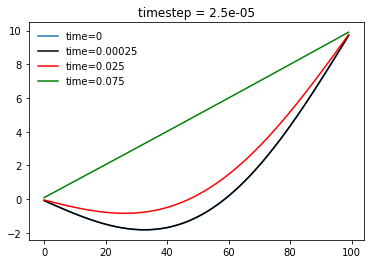

In [6]:
from matplotlib import pyplot as plt
plt.plot(np.arange(0,100,dx),topography, label='time=0')

for i in range(10):
    topography=B.dot(topography)+r*boundary_vector
plt.plot(np.arange(0,100,dx),topography,color='k',label='time='+str(10*dt))

for i in range(990):
    topography=B.dot(topography)+r*boundary_vector
plt.plot(np.arange(0,100,dx),topography,color='r',label='time='+str(1000*dt))

for i in range(20000):
    topography=B.dot(topography)+r*boundary_vector
plt.plot(np.arange(0,100,dx),topography,color='g',label='time='+str(3000*dt))

plt.legend(loc='best',frameon=False)
plt.gca().set_title('timestep = '+str(dt))
np.random.seed()

#### An unstable example:

In [7]:
np.random.seed(3)
topography = np.cumsum(np.random.normal(0,1,100))
dx = 1
K = 2e4
dt = 20*dx**2/(2*K)
r = (K*dt)/(dx*2)
from scipy.sparse import diags
B = diags([r, 1-2*r, r], [-1, 0, 1], shape=(100, 100)).toarray()
left=0
right=10
boundary_vector = np.zeros(100)
boundary_vector[0]=left
boundary_vector[-1]=right 

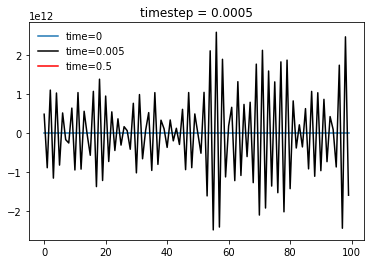

In [8]:
plt.plot(np.arange(0,100,dx),topography, label='time=0')

for i in range(10):
    topography=B.dot(topography)+r*boundary_vector
plt.plot(np.arange(0,100,dx),topography,color='k',label='time='+str(10*dt))

for i in range(990):
    topography=B.dot(topography)+r*boundary_vector
plt.plot(np.arange(0,100,dx),topography,color='r',label='time='+str(1000*dt))

plt.legend(loc='best',frameon=False)
plt.gca().set_title('timestep = '+str(dt))
np.random.seed()

## Implicit solution

In the **explicit** method above, we approximated ${\dfrac{\partial^2 h}{\partial x^2}}$ using the values of $h$ at the current time step, which we consider **known** quantities. 

$$\begin{equation}
\color{green}{\dfrac{\partial h}{\partial t}}
= 
K \color{blue}{\dfrac{\partial^2 h}{\partial x^2}}
\end{equation}$$

$$\begin{equation}
\color{green}{\dfrac{\mathrm{center_{future}} - \mathrm{center_{now}}}{\Delta t}}
\color{red}{\approx}
K \color{blue}{\dfrac{\mathrm{left} - 2~\mathrm{center} + \mathrm{right}}{\Delta x^2}}
\end{equation}$$



An **implicit** method, in contrast, evaluates some or all of $h$ in terms of **unknown** quantities at the new time step $t+\Delta t$. To solve the diffusion equation (1D) we will use an **implicit** method known as the [Crank-Nicholson method](https://en.wikipedia.org/wiki/Crank%E2%80%93Nicolson_method).

To approximate ${\dfrac{\partial^2 h}{\partial x^2}}$ we will be taking the average of the central difference approximation at the current time step and the central diference approximation at the next timestep.



    
$$\begin{equation*} 
\dfrac{\mathrm{center_{future}} - \mathrm{center_{now}}}{\Delta t} 
\approx
K\left(
\dfrac{\mathrm{left_{halfway~to~future}} - 2~\mathrm{center_{halfway~to~future}} + \mathrm{right_{halfway~to~future}}}
{\Delta x^2}\right)\\
\end{equation*} $$ 
    




$$\begin{equation*} 
\dfrac{\color{red}{\mathrm{center_{future}}}
- \mathrm{center_{now}}}{\Delta t} 
\approx
\dfrac{K}{2}
\left(\dfrac{\mathrm{left_{now}} - 2~\mathrm{center_{now}} + \mathrm{right_{now}}}
{\Delta x^2}
+
\dfrac{\color{red}{\mathrm{left_{future}}}
- 
2~\color{red}{\mathrm{center_{future}}} 
+ \color{red}{\mathrm{right_{future}}}}
{\Delta x^2}\right)
\\
\end{equation*} $$ 


$$\begin{equation*} 
\dfrac{\color{red}{h_{i}^{t+\Delta t}}
- h_i^t}{\Delta t} 
\approx
\dfrac{K}{2}
\left(
\dfrac{
            h_{i-\Delta x}^{t} 
            - 
            2~h_{i}^{t} 
            + 
            h_{i+\Delta x}^{t}
        }
        {
            \Delta x^2
        }
    +
    \dfrac{
            \color{red}{
                h_{i-\Delta x}^{t+\Delta t}
                       }
            -
            2~\color{red}{
                h_{i}^{t+\Delta t}
                         }
            +
            \color{red}{
                h_{i+\Delta x}^{t+\Delta t}
                       }
        }
        {
            \Delta x^2
        }
\right)
\\
\end{equation*} $$ 

$$\begin{equation*} 
\dfrac{\color{red}{h_{i}^{t+\Delta t}}
- h_i^t}{\Delta t} 
\approx
\dfrac{K}{2}
\left(
\dfrac{
            h_{i-\Delta x}^{t} 
            - 
            2~h_{i}^{t} 
            + 
            h_{i+\Delta x}^{t}
        }
        {
            \Delta x^2
        }
    +
    \dfrac{
            \color{red}{
                h_{i-\Delta x}^{t+\Delta t}
                       }
            -
            2~\color{red}{
                h_{i}^{t+\Delta t}
                         }
            +
            \color{red}{
                h_{i+\Delta x}^{t+\Delta t}
                       }
        }
        {
            \Delta x^2
        }
\right)
\\
\end{equation*} $$ 


and recall our definition: 
$\begin{equation}
r=K\dfrac{\Delta t}{2~\Delta x^2}
\end{equation}$

Which simplifies our equation to:
$$\begin{equation*} 
\color{red}{h_{i}^{t+\Delta t}}
-
h_i^t 
\approx
r~(h_{i-\Delta x}^{t} 
- 
2~h_{i}^{t} 
+ 
h_{i+\Delta x}^{t}
+
\color{red}{
h_{i-\Delta x}^{t+\Delta t}}
-
2~\color{red}{h_{i}^{t+\Delta t}}
+
\color{red}{h_{i+\Delta x}^{t+\Delta t}})
\\
\end{equation*} $$

Crank-Nicolson finite difference approximation to the 1D diffusion equation:
$$\begin{equation*} 
\color{red}{h_{i}^{t+\Delta t}}
-
h_i^t 
\approx
r~(h_{i-\Delta x}^{t} 
- 
2~h_{i}^{t} 
+ 
h_{i+\Delta x}^{t}
+
\color{red}{
h_{i-\Delta x}^{t+\Delta t}}
-
2~\color{red}{h_{i}^{t+\Delta t}}
+
\color{red}{h_{i+\Delta x}^{t+\Delta t}})
\\
\end{equation*} $$

Let's look at a space-time grid for the problem..

<center>
    <div style='height:40vh;'>
	    <p>
    </div>
</center>

Crank-Nicolson solution to the diffusion equation:
$$\begin{equation*} 
\color{red}{h_{i}^{t+\Delta t}}
-
h_i^t 
=
r~(h_{i-\Delta x}^{t} 
- 
2~h_{i}^{t} 
+ 
h_{i+\Delta x}^{t}
+
\color{red}{
h_{i-\Delta x}^{t+\Delta t}}
-
2~\color{red}{h_{i}^{t+\Delta t}}
+
\color{red}{h_{i+\Delta x}^{t+\Delta t}})
\\
\end{equation*} $$

<span style='color:DodgerBlue'>**Your assignment task this week is to determine the solution to the system of equations above (and then design some code that allows you to simulate changes in topography over time).**</span> 

Specific steps:
   1. Collect <span style='color:red'>**unknown**</span> terms on the left and **known** terms on the right.

   2. Convert this system of linear equations to matrix form (ie, figure out what goes in matrix $A$ and $B$ below):
$$
\begin{equation}
\begin{bmatrix}
\mathrm{A}\\
\end{bmatrix}
\color{red}{h^{t+\Delta t} }
=
\begin{bmatrix}
\mathrm{B}\\
\end{bmatrix}h^{t}
+
b^{t}
\end{equation}
$$

   3. Write your code (using the following pseudo code to guide you):
        - Set up initial conditions (topography, diffusivity, $\Delta x$, $\Delta t$, $r$) and boundary conditions (left and right)
        - Define matrices $A$ and $B$
        - Repeatedly (loop) solve the matrix equation above for $\color{red}{h^{t+\Delta t} }$ (each iteration is one $\Delta t$ sized step forward in time)

Here are some tricks for creating large matrices. First, define a matrix:

In [11]:
A = np.zeros((5,5)) #makes a 5 x 5 matrix
A

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

Change the main diagonal of a matrix:

In [12]:
np.fill_diagonal(A, 5)
np.fill_diagonal(A[1:], 4)
np.fill_diagonal(A[:,1:], 3)
A

array([[5., 3., 0., 0., 0.],
       [4., 5., 3., 0., 0.],
       [0., 4., 5., 3., 0.],
       [0., 0., 4., 5., 3.],
       [0., 0., 0., 4., 5.]])

Often there are several ways to accomplish a task. Scipy also has a nice solution for crafting matrices by diagonals:

In [13]:
from scipy.sparse import diags
B = diags([4, 5, 3], [-1, 0, 1], shape=(5, 5)).toarray()
B

array([[5., 3., 0., 0., 0.],
       [4., 5., 3., 0., 0.],
       [0., 4., 5., 3., 0.],
       [0., 0., 4., 5., 3.],
       [0., 0., 0., 4., 5.]])

We can use numpy to solve our matrix equation:

In [9]:
h = np.array([2,4,3,2,7]) #define vector
h

array([2, 4, 3, 2, 7])

In [14]:
np.linalg.solve(A,B.dot(h)) #solves for x in [A][x]=[B][h] ## SLOW

array([2., 4., 3., 2., 7.])

In [15]:
inverse_calculated_once = np.linalg.inv(A)
for i in range(100):
    inverse_calculated_once.dot(B.dot(h)) 
    #an alternative solution - solver above computed the right hand side of [A^-1][A]x = [A^-1][B][h]

array([2., 4., 3., 2., 7.])

<span style='color:DodgerBlue'>**A hint: the numpy solver above calculates the inverse of A with each call to the function. Generally speaking, inverting matrices is a computationally expensive step. If A doesn't change over time in your model, you can calculate the inverse once, set it to a new variable, and then use that inverted matrix for all time steps.**</span> 

In [16]:
%timeit np.linalg.solve(A,B.dot(h)) #calculates the inverse every time step

5.99 µs ± 112 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [17]:
C=np.linalg.inv(A) #calculate the inverse once
%timeit C.dot(B.dot(h))

891 ns ± 2.49 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
